In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.0.0'

In [2]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model 
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

Using TensorFlow backend.


In [19]:
TRAIN_PATH = 'Train'
TEST_PATH = 'Test'

BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 4


data_dir = pathlib.Path(TRAIN_PATH)    
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

In [4]:
# Run once to split data into train and test
# import os
# import shutil
# import numpy as np

# source_dir = "Train/"
# dest_dir = "Test/"
# classy = os.listdir(source_dir)
# # print(files)
# for class1 in classy:
# #     print(class1)
#     images = os.listdir(source_dir + class1 + '/')
# #     print(len(images))
#     for img in images:
#         if np.random.rand(1) < 0.2:
#             shutil.move(source_dir + class1 + '/' + img, dest_dir + class1 + '/' + img)

In [5]:
def data_generator(dir_path):
    data_dir = pathlib.Path(dir_path)    
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
    # print(CLASS_NAMES)
    image_count = len(list(data_dir.glob('*/*.jpg')))
    STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
    # The 1./255 is to convert from uint8 to float32 in range [0,1].
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                     brightness_range=[0.7, 1.0],)
    data_gen = image_generator.flow_from_directory(directory=str(data_dir),                                                    
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(CLASS_NAMES))
    return data_gen, STEPS_PER_EPOCH

In [6]:
def train_valid_generator(dir_path):
    data_dir = pathlib.Path(dir_path)    
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
    # print(CLASS_NAMES)
    image_count = len(list(data_dir.glob('*/*.jpg')))
    # The 1./255 is to convert from uint8 to float32 in range [0,1].
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                      validation_split=0.2,
                                                                    brightness_range=[0.7, 1.0],)
    
    train_gen = image_generator.flow_from_directory(directory=str(data_dir),                                                    
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(CLASS_NAMES),
                                                    subset='training')
    
    valid_gen = image_generator.flow_from_directory(directory=str(data_dir),                                                    
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(CLASS_NAMES),
                                                    subset='validation')
    
    
    return train_gen, valid_gen

In [7]:
train_data_gen, valid_data_gen = train_valid_generator(TRAIN_PATH)
test_data_gen, STEPS_TEST = data_generator(TEST_PATH)

Found 633 images belonging to 4 classes.
Found 157 images belonging to 4 classes.
Found 210 images belonging to 4 classes.


In [8]:
# for key, value in valid_data_gen:
#     print(value)
image_batch, label_batch = next(valid_data_gen)
for im in image_batch[:3]:
    print(im.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


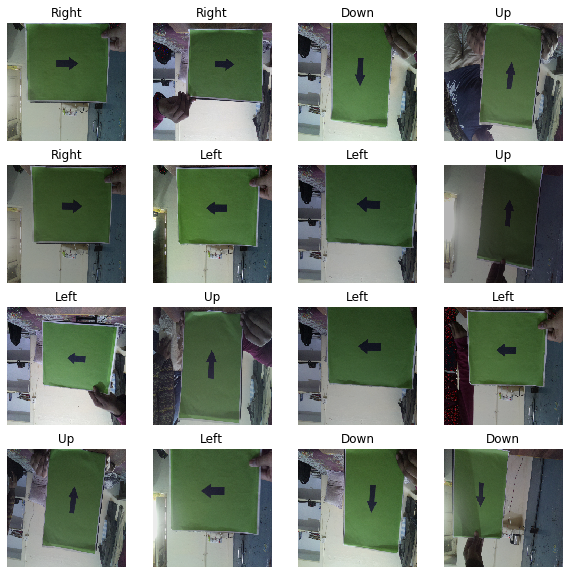

In [9]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [13]:
# model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3))

# for layer in model.layers[:5]:
#     layer.trainable = False

# #Adding custom Layers 
# x = model.output
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
# predictions = Dense(4, activation='softmax')(x)

from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [14]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc02c0aaa58> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c0aaac8> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c0aa6d8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc02c0c6438> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c0c6470> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c054dd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc02c06a320> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c06a358> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c07beb8> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c091390> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c021278> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc02c031390> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c031198> False
<keras.layers.convolutional.Conv2D object at 0x7fc02c045cc0> False
<keras.layers.convolutional.Conv2D object at 0x7fc01c7be668>

In [15]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 45,719,620
Trainable params: 32,774,660
Non-trainable params: 12,944,960
_________________________________________________________________


In [20]:
# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Train the model
history = model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=train_data_gen.samples//BATCH_SIZE,
    validation_data=valid_data_gen, 
    validation_steps=valid_data_gen.samples//BATCH_SIZE,
    epochs=EPOCHS)

now = datetime.now()
model.save('models/model_' + str(now) + '.h5')

Epoch 1/4
39/39 [==============================] - 329s 8s/step - loss: 0.3416 - acc: 0.8768 - val_loss: 0.5403 - val_acc: 0.8819
Epoch 2/4
39/39 [==============================] - 425s 11s/step - loss: 0.1468 - acc: 0.9595 - val_loss: 0.0482 - val_acc: 0.9504
Epoch 3/4
39/39 [==============================] - 449s 12s/step - loss: 0.0700 - acc: 0.9792 - val_loss: 0.3461 - val_acc: 0.8298
Epoch 4/4
39/39 [==============================] - 452s 12s/step - loss: 0.0364 - acc: 0.9918 - val_loss: 0.0119 - val_acc: 0.9716


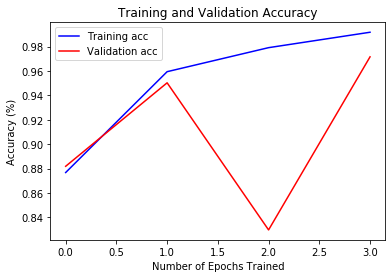

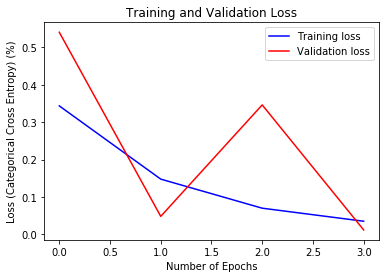

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs Trained')
plt.ylabel('Accuracy (%)')
plt.legend() 
plt.savefig(f'Training and Validation Accuracy.png')  
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (Categorical Cross Entropy) (%)')
plt.legend()
plt.savefig(f'Training and Validation loss.png')  
plt.show()

In [21]:
def NModel(input_shape):
    """    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """    
    ### START CODE HERE ###    
    X_input = Input(input_shape)
    #  Trying VGG Style Architecture CONV
    # Layer 1 CONV1 with 3x3 filters    
    X = ZeroPadding2D((1, 1))(X_input)    
    
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1')(X)    
    # X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv2')(X)        
    
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)

    # Layer 2 CONV2 with 5x5 filters    
    X = ZeroPadding2D((2, 2))(X_input)    
    
    X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv3')(X)
    # X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv4')(X)
    
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    
    # Layer 3 FC     
    X = Flatten()(X)    
    # Adding More FC layers results in very bad performance?    
    X = Dense(4, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X)
    ### END CODE HERE ###    
    return model

In [27]:
model = NModel((224, 224, 3))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [28]:
# model.fit_generator(generator=train_data_gen,
#                     steps_per_epoch=STEPS_TRAIN,
#                     # validation_data=valid_data_gen,
#                     # validation_steps=STEPS_VALID,
#                     epochs=EPOCHS
# )

model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=train_data_gen.samples//BATCH_SIZE,
    validation_data=valid_data_gen, 
    validation_steps=valid_data_gen.samples//BATCH_SIZE,
    epochs=EPOCHS)

now = datetime.now()
model.save('models/model_' + str(now) + '.h5')

Epoch 1/5
39/39 [==============================] - 35s 902ms/step - loss: 20.7517 - accuracy: 0.7650 - val_loss: 4.3160 - val_accuracy: 0.5486
Epoch 2/5
39/39 [==============================] - 43s 1s/step - loss: 0.7701 - accuracy: 0.9660 - val_loss: 0.0769 - val_accuracy: 0.9504
Epoch 3/5
39/39 [==============================] - 47s 1s/step - loss: 0.7216 - accuracy: 0.9724 - val_loss: 2.2761 - val_accuracy: 0.7801
Epoch 4/5
39/39 [==============================] - 52s 1s/step - loss: 1.3784 - accuracy: 0.9562 - val_loss: 0.1547 - val_accuracy: 0.9787
Epoch 5/5
39/39 [==============================] - 53s 1s/step - loss: 0.2448 - accuracy: 0.9854 - val_loss: 0.0867 - val_accuracy: 0.9007


In [182]:
test_data_gen.reset()
pred = model.predict_generator(test_data_gen,
                            steps=test_data_gen//BATCH_SIZE,
                            verbose=1,
                            use_multiprocessing=True)

predicted_class_indices=np.argmax(pred, axis=1)

labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

4/4 [==============================] - 1s 350ms/step
{0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}


In [23]:
# test_data_gen.reset()
# image_batch, label_batch = next(test_data_gen)
# print(pred, label_batch)
test_data_gen.reset()
loss, acc = model.evaluate_generator(test_data_gen,                                     
                                    verbose=1, 
                                    use_multiprocessing=True)
print(loss, acc)

14/14 [==============================] - 73s 5s/step
0.0 0.9476190209388733


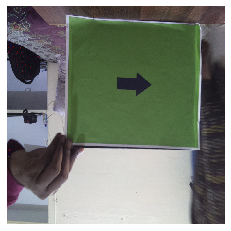

{'Up': 0, 'Right': 1, 'Down': 2, 'Left': 3}
[1]


In [25]:
def load_image(img_path, show=False):
#     print(type(image))
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
        
    return img_tensor

# img_path = '/home/kartikey/Desktop/BTPv2/Test/Left/image17.W41Iv.jpg'    #Left
# img_path = '/home/kartikey/Desktop/BTPv2/Test/Down/image27.Dq5b4.jpg'    #Down
# img_path = '/home/kartikey/Desktop/BTPv2/Test/Right/image25.jpg'         #Right
img_path = '/home/kartikey/Desktop/Semester VII/BTPv2/Test/Right/image1.jpg'
model_loaded = model
# model_loaded = load_model('models/model_2019-11-27 09:09:56.973985.h5')
new_image = load_image(img_path, show=True)
pred = model_loaded.predict(new_image)
predicted_class_indices=np.argmax(pred, axis=1)
labels = (train_data_gen.class_indices)
print(labels)
print(predicted_class_indices)